# ARMA, ARIMA, SARIMA

## Overview

In the previous four lessons, we learned about stationarity, smoothing, trend, seasonality, and autocorrelation, and you built two different kinds of models: 

- **MA models**: The current value of the series depends linearly on the series' mean and a set of prior (observed) white noise error terms.

- **AR models**: The current value of the  series depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term).
  
In this lesson we will review these concepts and combine the AR and MA models into three more complicated ones: ARMA, ARIMA, and SARIMA.

In particular, we will cover:

1. Autoregressive Moving Average (ARMA) models.
2. Autoregressive Integrated Moving Average (ARIMA) models.
3. SARIMA models (ARIMA model for data with seasonality).
4. Selecting the best model.

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install -U -qq tsa-course pmdarima

In [2]:
# Imports
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import statsmodels.api as sm
import seaborn as sns
# from tqdm.notebook import tqdm
from scipy import stats
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import ccf, adfuller
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_process import arma_generate_sample
# %pip install pmdarima
# import pmdarima as pm
# from tsa_course.lecture1 import fft_analysis
np.random.seed(0)                

---

## ARMA

The ARMA model (also known as the *Box-Jenkins* approach) combines two models:

- An autoregressive (AR) model of order $p$.
- A moving average (MA) model of order $q$.

- When we have autocorrelation between outcomes and their ancestors, there will be a pattern in the time series. 
- This relationship can be modeled using an ARMA model. 
- It allows us to predict the future with a confidence level proportional to the strength of the relationship and the proximity to known values.

**📝 Note**

- ARMA models assume the time series is assumed to be stationary.
- A good rule of thumb is to have at least 100 observations when fitting an ARMA model.

### Load data

- In the following, we'll look at the monthly average temperatures between 1907-1972.

In [3]:
# load data and convert to datetime
monthly_temp = pd.read_csv('https://zenodo.org/records/10951538/files/arima_temp.csv?download=1', 
                           skipfooter=2, header=0, index_col=0, names=['month', 'temp'], engine='python')
monthly_temp.index = pd.to_datetime(monthly_temp.index)

- This is how the data looks like.

In [4]:
monthly_temp.tail()

,temp
month,
1972-08-01,75.6
1972-09-01,64.1
1972-10-01,51.7
1972-11-01,40.3
1972-12-01,30.3


- These are some statistics.

In [5]:
monthly_temp.describe()

,temp
count,792.000000
mean,53.553662
std,15.815452
min,11.200000
25%,39.675000
50%,52.150000
75%,67.200000
max,82.400000


- This is the run sequence plot.

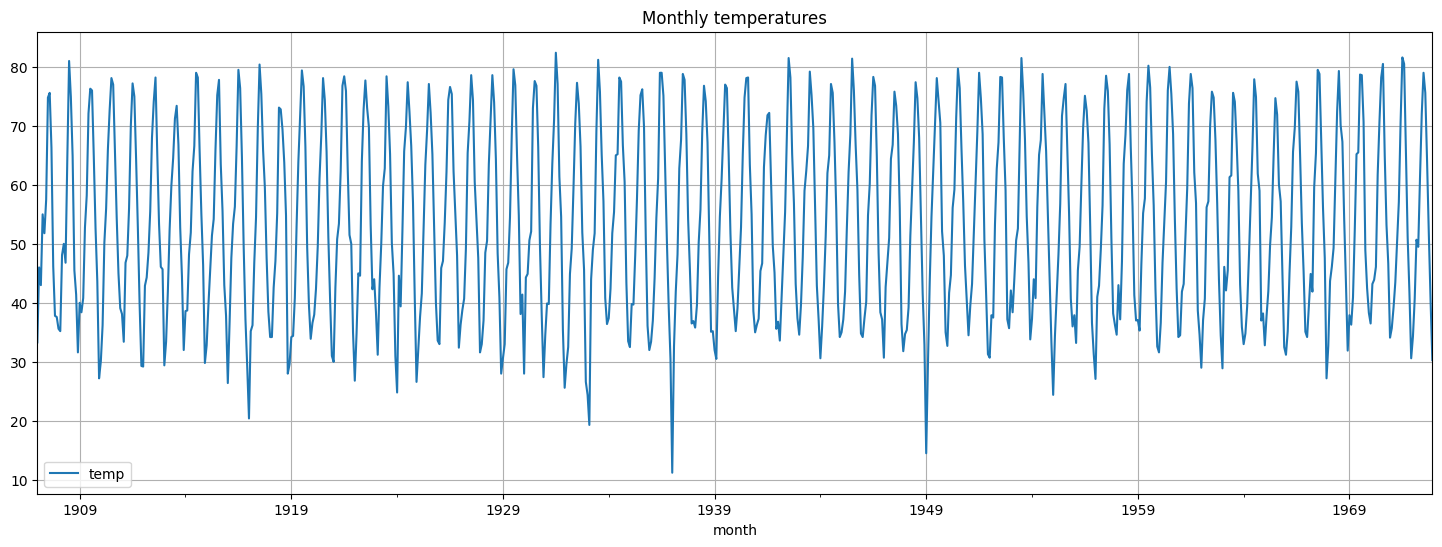

In [6]:
monthly_temp.plot(grid=True, figsize=(18,6), title='Monthly temperatures');

- Compute the annual mean and plot it on top of the actual data.

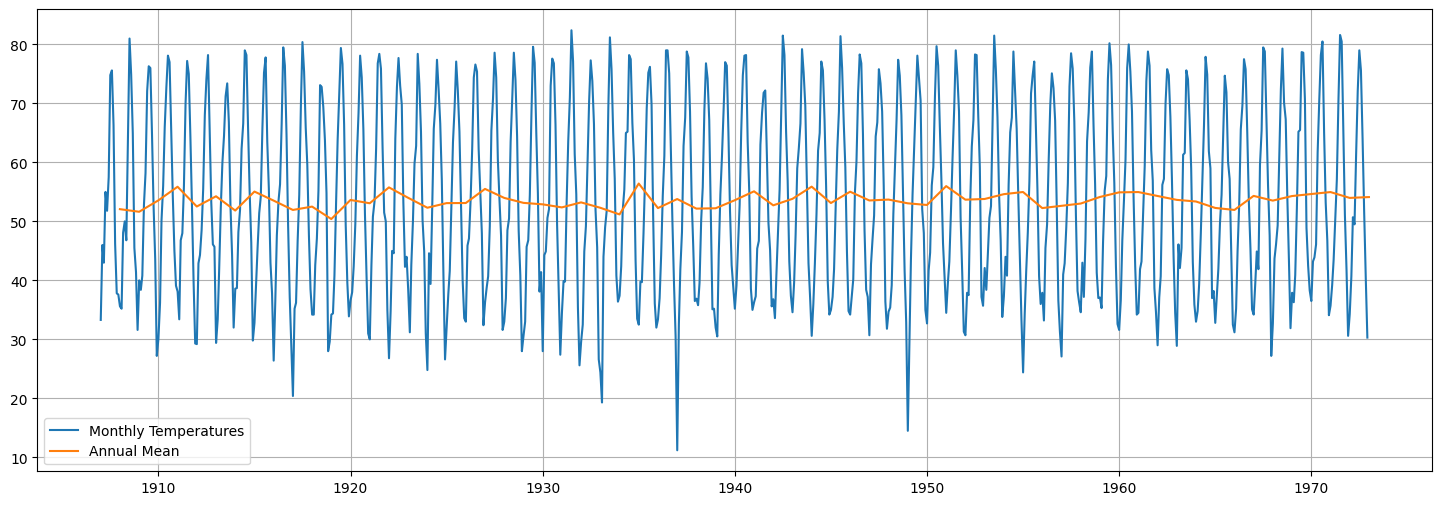

In [7]:
# Compute annual mean 
annual_temp = monthly_temp.resample('YE').mean() # annual_temp = monthly_temp.rolling(12).mean()
annual_temp.index.name = 'year'

plt.figure(figsize=(18,6))
plt.plot(monthly_temp, label="Monthly Temperatures")
plt.plot(annual_temp, label="Annual Mean")
plt.grid(); plt.legend();

- This gives us an indication that the mean is rather constant over the years.
- We can extract further information abouth the underlying trend and seasonality by performing a seasonal decomposition.
- We can use both the `seasonal_decompose` and the `STL` methods.

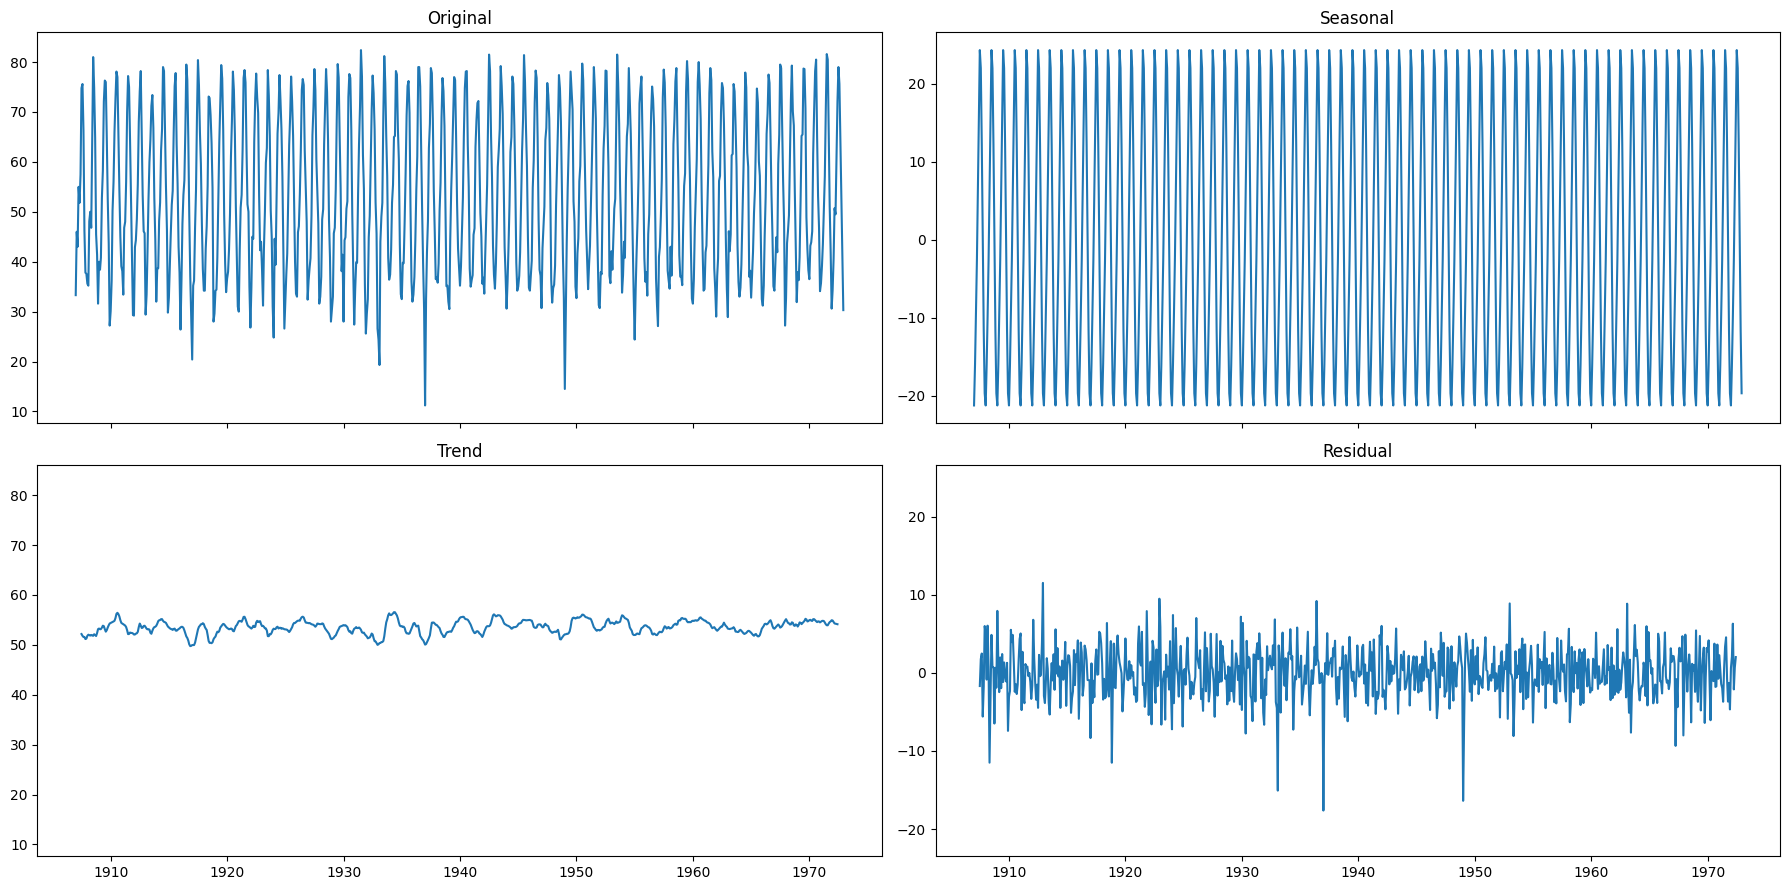

In [8]:
decomposition = seasonal_decompose(x=monthly_temp['temp'], model='additive', period=12)
seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,9))
axs[0,0].plot(monthly_temp['temp']); axs[0,0].set_title('Original')
axs[0,1].plot(seasonal); axs[0,1].set_title('Seasonal')#; axs[0,1].set_ylim(axs[0,0].get_ylim())
axs[1,0].plot(trend); axs[1,0].set_title('Trend'); axs[1,0].set_ylim(axs[0,0].get_ylim())
axs[1,1].plot(resid); axs[1,1].set_title('Residual'); axs[1,1].set_ylim(axs[0,1].get_ylim())
plt.tight_layout()

- The seasonality is well defined.
- Trend doesn't seem to be a strong and time-varying.
    - We can assume the trend is constant (for stationarity).
    
---

## ARMA modeling stages

There are three stages in building an ARMA model:

1. Model identification.
2. Model estimation.
3. Model evaluation.

### Model identification

- Model identification consists in finding the orders $p$ and $q$ AR and MA components.
- Before performing model identification we need to:
    1. Determine if the time series is stationary.
    2. Determine if the time series has seasonal component.

#### Determine stationarity

- We can use tools we already know (such as ADF test).
- We can also look at the rolling mean and rolling std.

<br>
<div style="text-align: center; font-size: 30px; font-weight: bold;">⚠ Attention! ⚠</div>
<br>

- Before we continue, let's consider the following result

In [9]:
sinusoid = np.sin(np.arange(200))
testval, pval, _, _, _, _ = adfuller(sinusoid)
print(testval, pval)

-1.3451537116176384e+16 0.0


<!-- - Periodic signals, by their nature, have means and variances that repeat over the period of the cycle. 
- This implies that their statistical properties are functions of time within each period. 
- For instance, the mean of a periodic signal over one cycle may be constant.
- However, when considering any point in time relative to the cycle, the instantaneous mean of the signal can vary. 
- Similarly, the variance can fluctuate within the cycle. -->

- The ADF test specifically looks for shocks to the time series that have a **permanent** effect (causing drifts in the level of the series). 
- A sinusoidal function, by contrast, is inherently *mean-reverting* within its cycles.
- After a peak a sinusoid reverts to its mean and fluctuations are not persisting.

- It's crucial to note that the ADF test's conclusion of stationarity for a sinusoid does not imply that the sinusoid is stationary. 
- The test's conclusion is about the absence of permanent shocks.
- Obviously the mean is not near constant **within periodic cycles**.

---

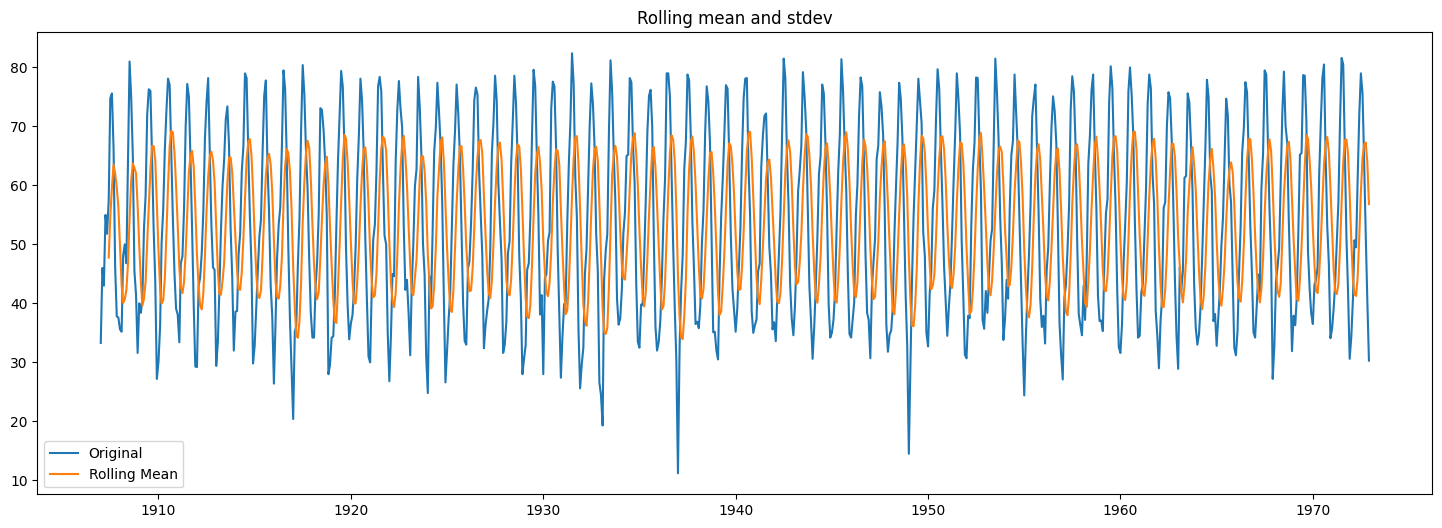

In [10]:
plt.figure(figsize=(18, 6))
plt.plot(monthly_temp.temp, label='Original')
plt.plot(monthly_temp.temp.rolling(window=6).mean(), label='Rolling Mean')
# plt.plot((np.cumsum(monthly_temp.temp) / np.arange(1,len(monthly_temp)+1))[:100], label='Non-rolling Mean')
# plt.plot(monthly_temp.temp.rolling(window=12).std(), label = 'Rolling Std')
plt.title('Rolling mean and stdev')
plt.legend()

- The rolling mean and rolling standard deviation seem globally constant along the time series...
- ... even if they change locally within the period.

#### Determine seasonality

We can determine if seasonality is present by using the following tools:
- Autocorrelation plot.
- Seasonal subseries plot (month plot).

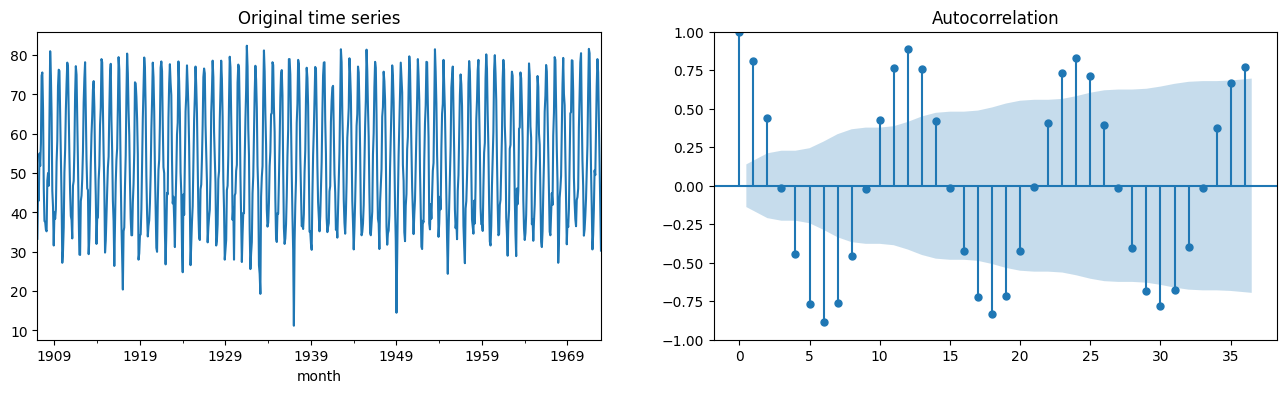

In [11]:
fig, axes = plt.subplots(1,2,figsize=(16,4))
monthly_temp['temp'].plot(ax=axes[0], title="Original time series")

# ACF Plot
plot_acf(monthly_temp['temp'][:200], lags=36, ax=axes[1]);
monthly_temp['month'] = monthly_temp.index.month;

- Let's look at `month_plot`

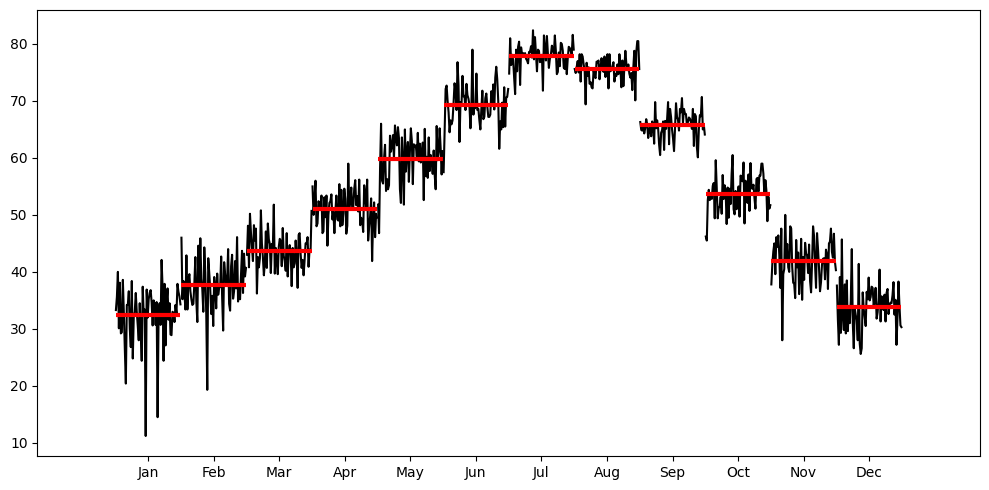

In [12]:
fig, ax= plt.subplots(1,1,figsize=(10,5))
month_plot(monthly_temp['temp'], ax=ax)
plt.tight_layout();

- Notice that a `violinplot` can give a very similar information to the `month_plot`.

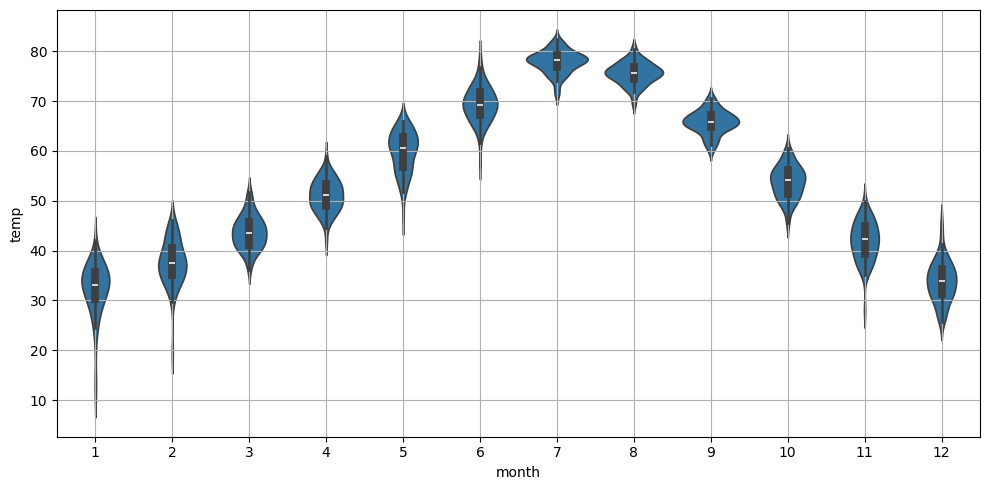

In [13]:
fig, ax= plt.subplots(1,1,figsize=(10,5))
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp, ax=ax) # notice the indexing on the x by month
plt.tight_layout()
plt.grid();

#### Remove the main seasonality

- In this case, it is clear that the main seasonality is $L=12$.
- We can remove it with a seasonal differencing.

In [14]:
monthly_temp['seas_diff'] = monthly_temp['temp'].diff(12)
monthly_temp = monthly_temp.dropna()
# note the difference between np.diff() and df.diff()

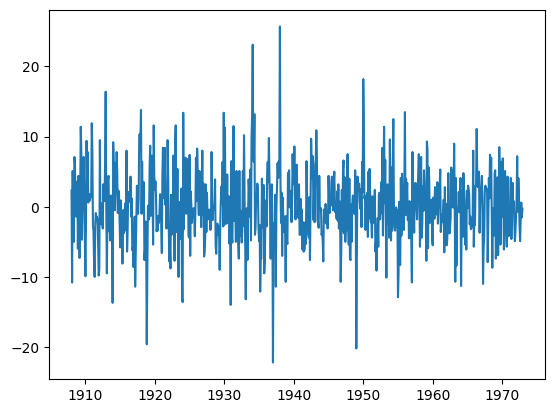

In [15]:
plt.plot(monthly_temp['seas_diff'])

**⚙ Try it yourself**

- Try redoing the previous plots on the differenced data!

#### Identifying $p$ and $q$

As we learned in the previous lesson, we will identify the AR order $p$ and the MA order $q$ with:

- Autocorrelation function (ACF) plot.
- Partial autocorrelation function (PACF) plot.

**AR($p$)**

- The order of the AR model is identified as follows:
    - Plot 95% confidence interval on the PACF (done automatically by statsmodels).
    - Choose lag $p$ such that the partial autocorrelation becomes insignificant for $p+1$ and beyond.

- If a process depends on **previous values** of itself then it is an AR process. 
- If it depends on **previous errors**, then it is an MA process.
- An AR process propagates shocks infinitely.
- AR processes will exhibit exponential decay in ACF and a cut-off in PACF.

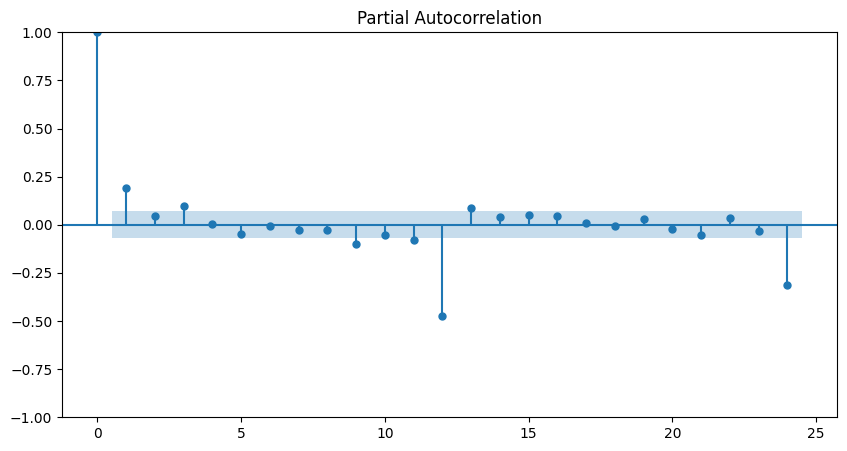

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plot_pacf(monthly_temp['seas_diff'], lags=24, ax=ax); 

- It looks like the PACF becomes zero at lag 2.
- However there is a non-zero partial autocorrelation at lag 3.
- The optimal value might be $p=1$, $p=2$, or $p=3$.
- Note that there are high partial autocorrelations at higher lags, especially 12. 
    - This is an effect from seasonality and seasonal differencing. 
    - It should not be accounted when chosing $p$.

**MA($q$)**

- The order of the MA model is identified as follows:
    - Plot 95% confidence interval on the ACF (done automatically by statsmodels).
    - Choose lag $q$ such that ACF becomes statistically zero for $q+1$ and beyond.

- MA models do not propagate shocks infinitely; they die after $q$ lags.
- MA processes will exhibit exponential decay in PACF and a cut-off in ACF

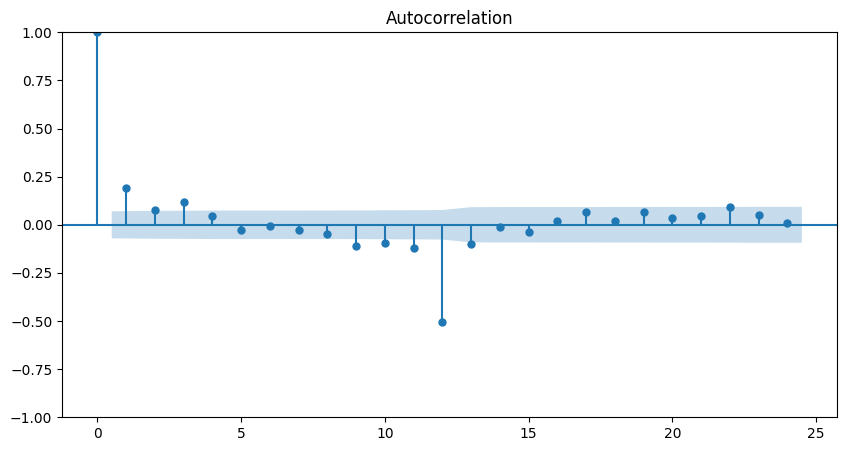

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plot_acf(monthly_temp['seas_diff'], lags=24, ax=ax); 

- Also in this case there are non-zero autocorrelations at lags 1 and 3.
- So, the values to try are $q=1$, $q=2$, or $q=3$.

### Model estimation

- Once the orders $p$ and $q$ are identified, now estimate parameters $\phi_1, \dots, \phi_p$ of the AR part, and $\theta_1, \dots, \theta_q$ of the MA part.
- Estimating the parameters of an ARMA model is a complicated, nonlinear problem.
- Nonlinear least squares regression and maximum likelihood estimation (MLE) are common approaches.
- Many modern software programs will fit the ARMA model for us.

- We split the data in two parts:
    - the training set, that will be used to fit the model's parameters.
    - the test set, that will be used later on to evaluate the prediction performance of the model on unseen data.

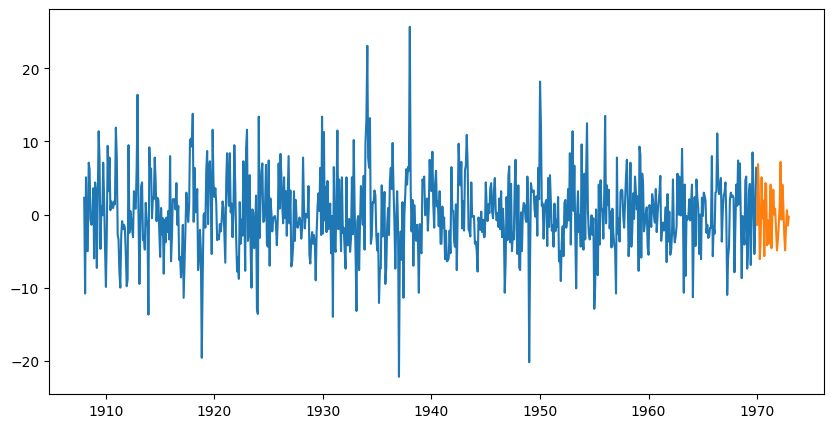

In [18]:
train = monthly_temp['seas_diff'][:-36] 
test = monthly_temp['seas_diff'][-36:]

plt.figure(figsize=(10,5))
plt.plot(train)
plt.plot(test);

**Grid searching for best model by forecasting performance**

In [19]:
%%time
best_RMSE = np.inf
for p in range(1,4):
    for d in [0]:
        for q in range(1,4):
            try:
                model = ARIMA(train, order=(p,d,q))  # ARIMA with d=0 is equivalent to ARMA
                fit_model = model.fit()
                forecast = fit_model.forecast(len(test))
                # forecast = fit_model.predict(test.index[0],test.index[-1])
                # predict = fit_model.predict()
            except:
                pass
            else:
                MAPE = (abs((test-forecast))/test).mean() # not suitable for data containing 0s
                RMSE = mse(test, forecast)**0.5
                AIC = fit_model.aic
                BIC = fit_model.bic
                if RMSE < best_RMSE:
                    best_model = (p,d,q)
                    best_RMSE = RMSE
                print('ARIMA(%.0f,%.0f,%.0f) -> MAPE:%.3f, RMSE:%.3f, AIC:%.1f, BIC:%.1f' % (p,d,q, MAPE, RMSE, AIC, BIC))
print('Best model by RMSE (Forecast):',best_model)

ARIMA(1,0,1) -> MAPE:inf, RMSE:3.501, AIC:4565.5, BIC:4583.9
ARIMA(1,0,2) -> MAPE:inf, RMSE:3.505, AIC:4567.3, BIC:4590.3
ARIMA(1,0,3) -> MAPE:inf, RMSE:3.511, AIC:4564.3, BIC:4592.0
ARIMA(2,0,1) -> MAPE:inf, RMSE:3.504, AIC:4567.3, BIC:4590.4
ARIMA(2,0,2) -> MAPE:inf, RMSE:3.447, AIC:4541.0, BIC:4568.7
ARIMA(2,0,3) -> MAPE:inf, RMSE:3.614, AIC:4503.0, BIC:4535.3
ARIMA(3,0,1) -> MAPE:inf, RMSE:3.507, AIC:4564.6, BIC:4592.3
ARIMA(3,0,2) -> MAPE:inf, RMSE:3.598, AIC:4503.8, BIC:4536.1
ARIMA(3,0,3) -> MAPE:inf, RMSE:3.184, AIC:4512.1, BIC:4549.0
Best model by RMSE (Forecast): (3, 0, 3)
CPU times: total: 5.55 s
Wall time: 6.16 s


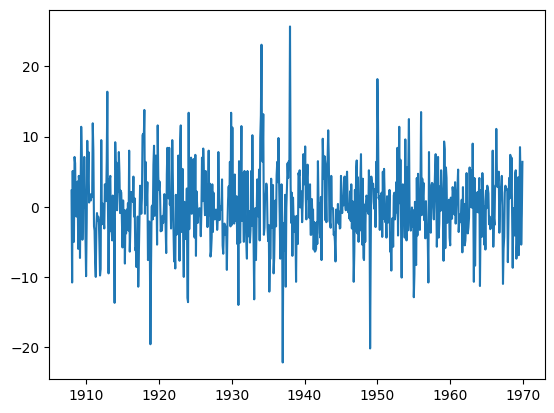

In [20]:
plt.plot(train)

### ARMA Model Validation

- How do you know if your ARMA model is fairly good?
- We can check the resiudals, i.e., what the model was not able to fit.
- The residuals should approximate a Gaussian distribution (aka white noise).
- Otherwise, we might need to select a better model.

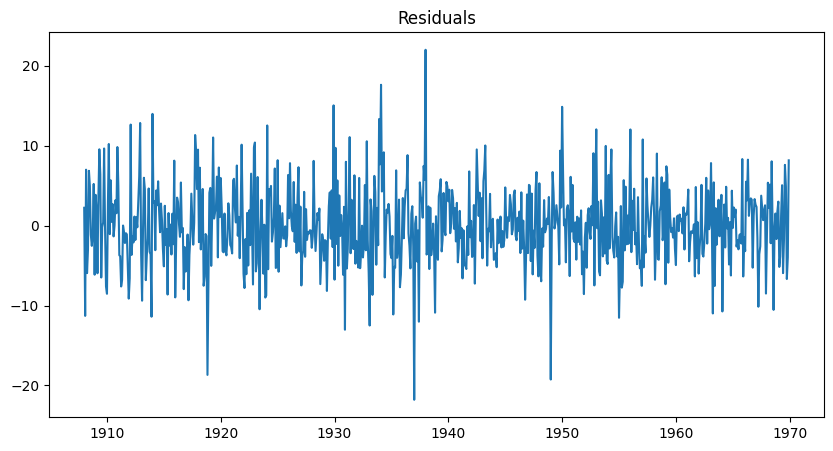

In [21]:
best_model = ARIMA(train, order=(3,0,3))  # ARIMA with d=0 is equivalent to ARMA
fit_best_model = best_model.fit()
residuals = fit_best_model.resid

plt.figure(figsize=(10,5))
plt.plot(residuals)
plt.title("Residuals");

**🤔 How to test if the residuals look like noise?**

- We will use both visual inspection and statistical tests.
- Visual inspection:
    - ACF plot.
    - Histogram.
    - QQ plot.
- Statistical tests:
    - Normality.
    - Autocorrelation.
    - Heteroskedasticity.

#### Visual inspection 

**ACF plot**

- Checks for any autocorrelation in the residuals. 
- White noise should show no significant autocorrelation at all lags.

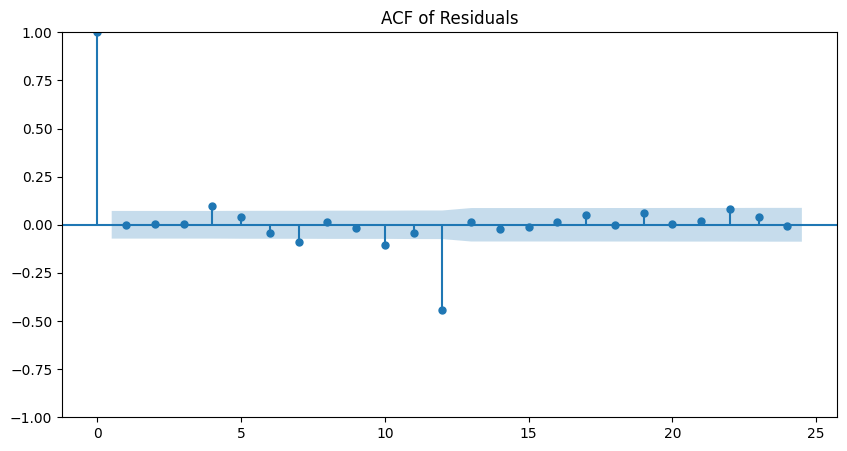

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_acf(residuals, lags=24, ax=ax)
plt.title('ACF of Residuals')
plt.show()

**Histogram and QQ-Plot**
- Assess the normality of the residuals. 
- White noise should ideally follow a normal distribution.

- The plots are conveniently summarized in the function ``plot_diagnostics()`` that can be called on the fit model.

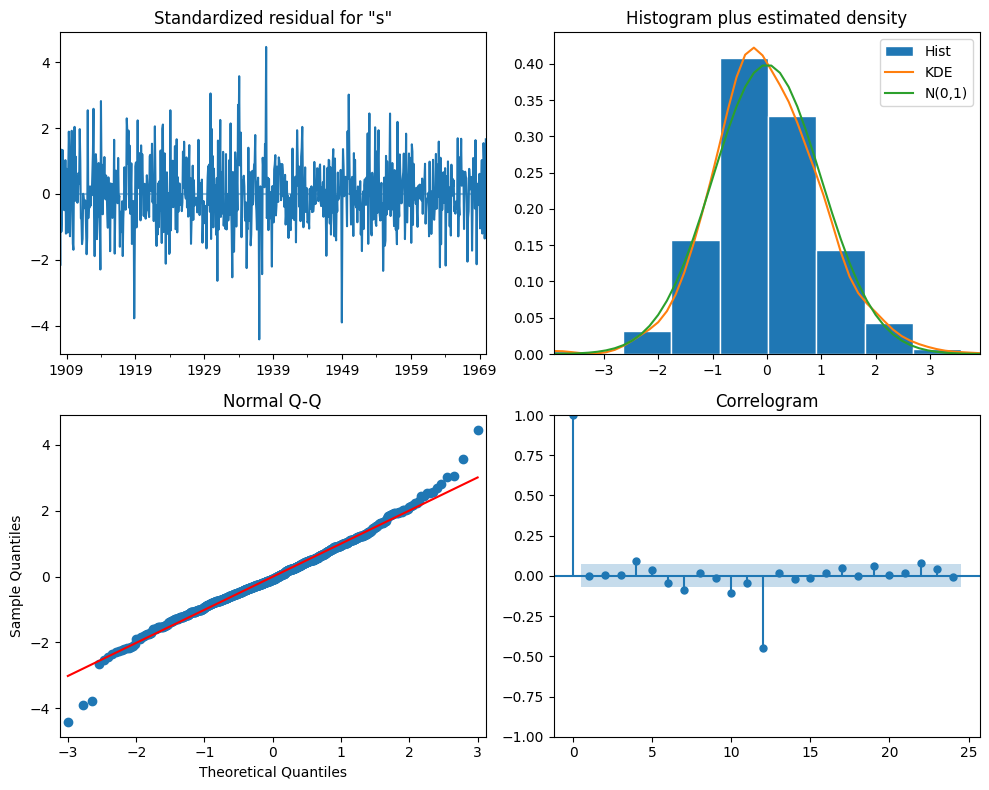

In [23]:
fit_model.plot_diagnostics(figsize=(10, 8),lags=24)
plt.tight_layout();

**Summary of tests**

Independence / Autocorrelation:
- &#x2705; ACF plot.
- &#x2705; Ljung-Box test.
- &#x2705; Durbin Watson test.

Normality:
- &#x2705; Histogram/Density plot.
- 🤔 QQ-plot
- &#x274C; Jarque-Bera (reliable for large sample size).
- &#x274C; Shapiro-Wilk (reliable for large sample size).

Heteroskedasticity
- &#x274C; Heteroskedasticity test.

### ARMA Model Predictions

- Once the model is fit, we can use it to predict the test data.
- The predictions come in a form of a distribution.
- In other words, ARMA performs a *probabilistic forecasting*.
- The mean (mode) of this distribution correspond to the most likely value and correspond to our forecast
- The rest of the distribution can be used to compute confidence intervals.

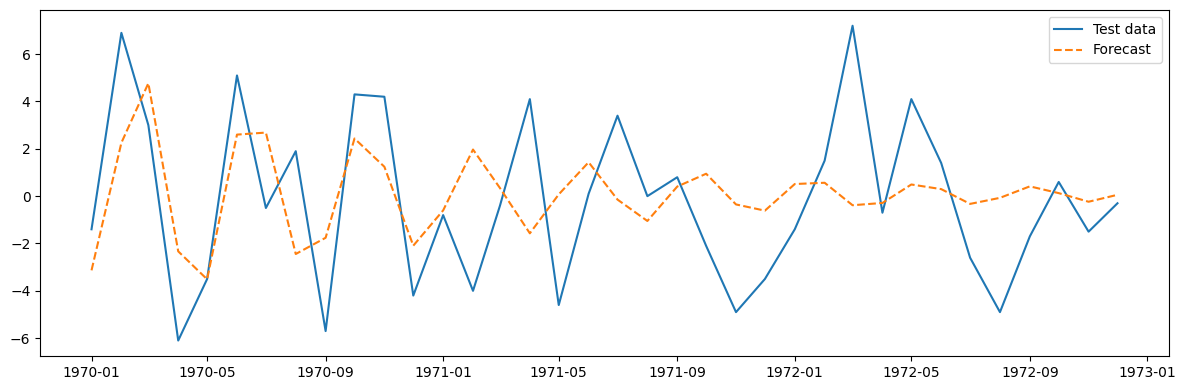

In [24]:
arma_fore = fit_best_model.forecast(len(test))
# arma_fore = fit_best_model.predict(test.index[0], test.index[-1])

plt.figure(figsize=(12, 4))
plt.plot(test.index, test, label='Test data')
plt.plot(test.index, arma_fore, label='Forecast', linestyle='--')

plt.legend()
plt.tight_layout();

In [25]:
fit_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              seas_diff   No. Observations:                  744
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -2248.065
Date:                Tue, 23 Dec 2025   AIC                           4512.131
Time:                        23:10:23   BIC                           4549.027
Sample:                    01-01-1908   HQIC                          4526.353
                         - 12-01-1969                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0652      0.244      0.268      0.789      -0.413       0.543
ar.L1         -0.0923      0.140     -0.657      0.511      -0.368       0.183
ar.L2         -0.8289      0.023    -35.696      0.000      -0.874      -0.783
ar.L3          0.0463      0.122      0.379      0.705      -0.193       0.286
ma.L1          0.2838      0.139      2.041      0.041       0.011       0.556
ma.L2          0.9968      0.012     85.681      0.000       0.974       1.020
ma.L3          0.2400      0.139      1.723      0.085      -0.033       0.513
sigma2        24.3150      1.007     24.135      0.000      22.340      26.290
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                56.76
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.12
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

---

## ARIMA Model

- ARIMA stands for Auto Regressive **Integrated** Moving Average. 
- ARIMA models have three components:
    - AR model.
    - Integrated component (more on this shortly).
    - MA model.

- The ARIMA model is denoted ARIMA($p, d, q$).
    - $p$ is the order of the AR model.
    - $d$ is the number of times to difference the data.
    - $q$ is the order of the MA model.
    - $p$, $d$, and $q$ are nonnegative integers.

- As we saw previously, differencing nonstationary time series data one or more times can make it stationary. 
- That’s the role of the integrated (I) component of ARIMA.
- $d$ is the number of times to perform a lag 1 difference on the data.
    - $d=0$: no differencing. 
    - $d=1$: difference once. 
    - $d=2$: difference twice. 

- The ARMA model is suitable for stationary time series where the mean and variance do not change over time.
- The ARIMA model effectively models non-stationary time series by differencing the data.
- In practice, ARIMA makes the time series stationary before applying the ARMA model.
- Let's see it with an example.

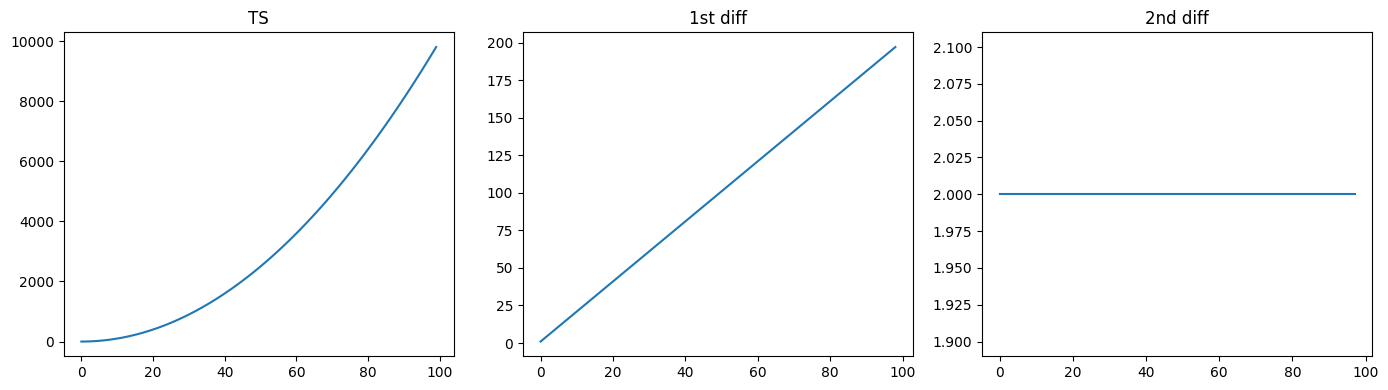

In [26]:
time = np.arange(100)
ts = time**2 #+ np.random.normal(0,100,100)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].plot(ts); axs[0].set_title('TS')
axs[1].plot(np.diff(ts,1)); axs[1].set_title('1st diff')
axs[2].plot(np.diff(ts,2)); axs[2].set_title('2nd diff')
plt.tight_layout();

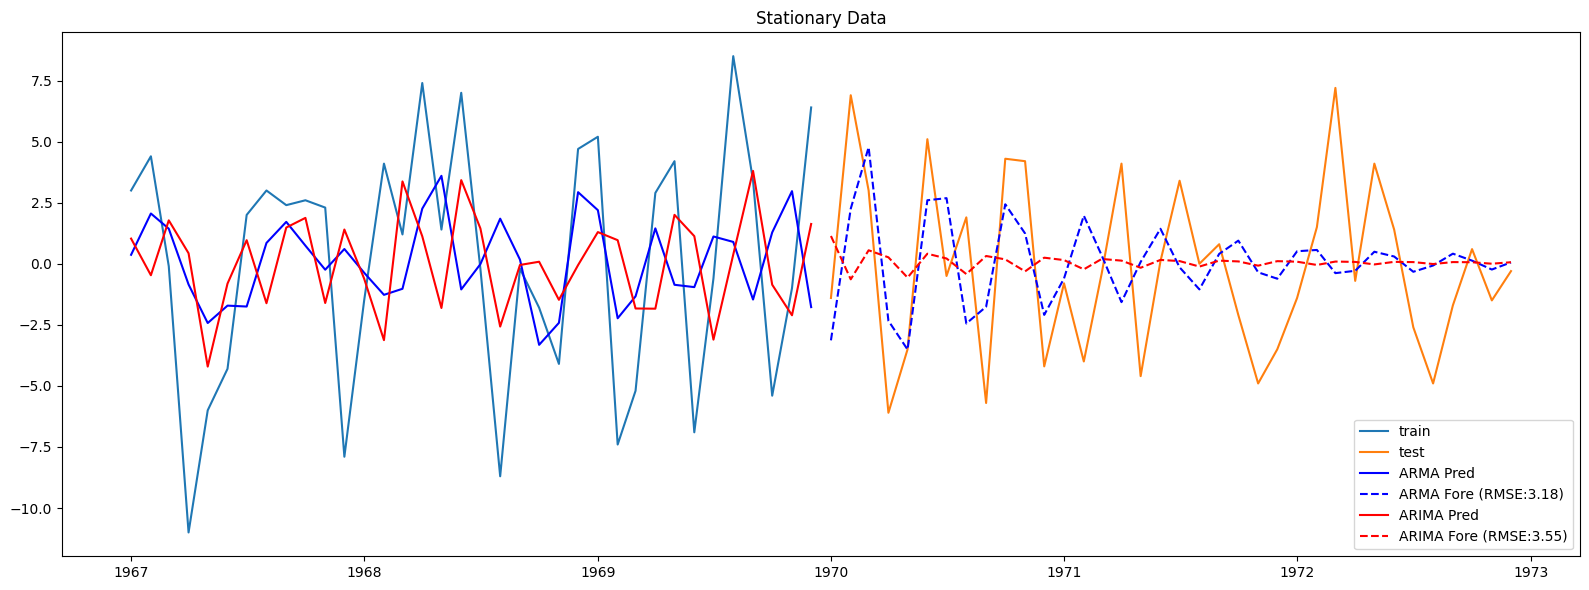

In [27]:
# Fit models to stationary data
train = monthly_temp['seas_diff'][:-36] 
test = monthly_temp['seas_diff'][-36:]

arma_fit = ARIMA(train, order=(3, 0, 3)).fit()
arima_fit = ARIMA(train, order=(3, 1, 3)).fit()
arma_pred = arma_fit.predict(); arima_pred = arima_fit.predict()
arma_fore = arma_fit.forecast(len(test)); arima_fore = arima_fit.forecast(len(test)); 

plt.figure(figsize=(16,6))
plt.plot(train[-36:], label='train')
plt.plot(test, label='test')
plt.plot(arma_pred[-36:], 'b', label='ARMA Pred')
plt.plot(arma_fore, 'b--', label='ARMA Fore (RMSE:%.2f)' % mse(arma_fore,test)**0.5)
plt.plot(arima_pred[-36:], 'r', label='ARIMA Pred')
plt.plot(arima_fore, 'r--', label='ARIMA Fore (RMSE:%.2f)' % mse(arima_fore,test)**0.5)
plt.legend(loc='lower right')
plt.title('Stationary Data')
plt.tight_layout();

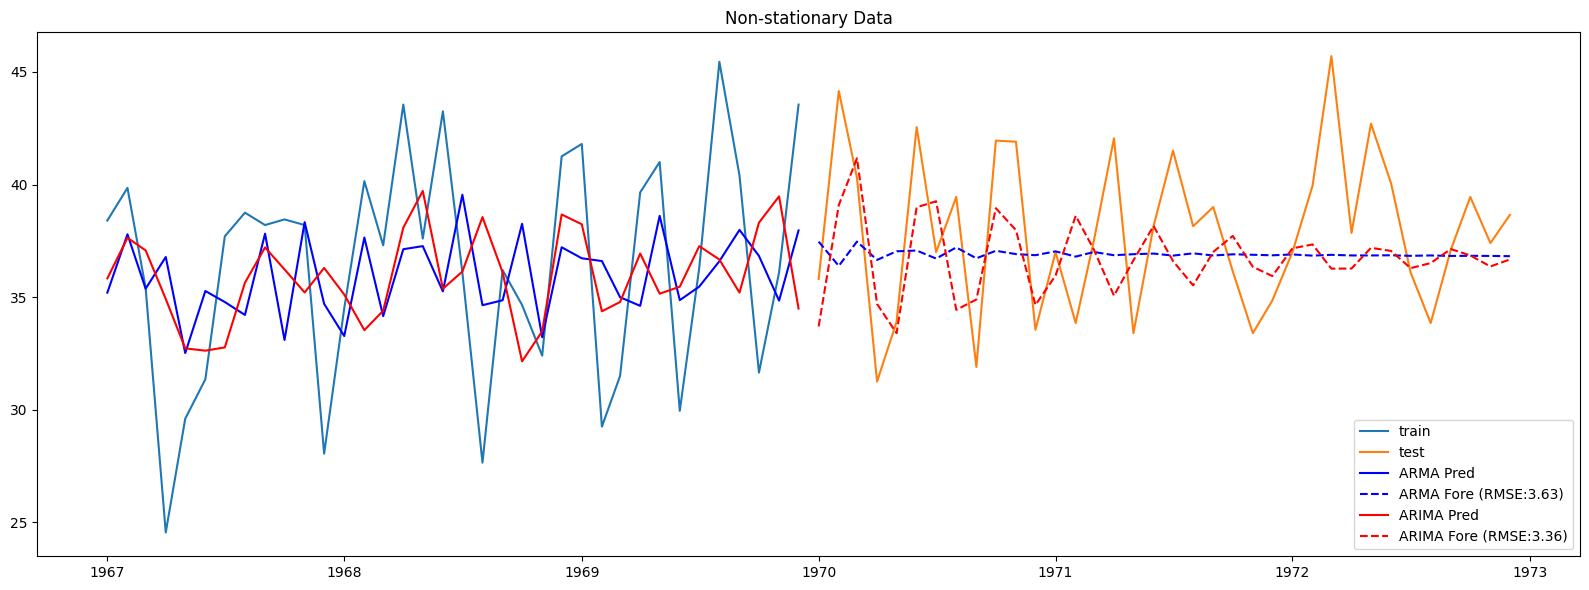

In [28]:
time = np.arange(len(monthly_temp))
monthly_temp['seas_diff_wtrend'] = monthly_temp['seas_diff'] + 0.05*time

# Fit models to non-stationary data
train = monthly_temp['seas_diff_wtrend'][:-36] 
test = monthly_temp['seas_diff_wtrend'][-36:]

arma_fit = ARIMA(train, order=(3, 0, 3)).fit()
arima_fit = ARIMA(train, order=(3, 1, 3)).fit()
arma_pred = arma_fit.predict(); arima_pred = arima_fit.predict()
arma_fore = arma_fit.forecast(len(test)); arima_fore = arima_fit.forecast(len(test)); 

plt.figure(figsize=(16,6))
plt.plot(train[-36:], label='train')
plt.plot(test, label='test')
plt.plot(arma_pred[-36:], 'b', label='ARMA Pred')
plt.plot(arma_fore, 'b--', label='ARMA Fore (RMSE:%.2f)' % mse(arma_fore,test)**0.5)
plt.plot(arima_pred[-36:], 'r', label='ARIMA Pred')
plt.plot(arima_fore, 'r--', label='ARIMA Fore (RMSE:%.2f)' % mse(arima_fore,test)**0.5)
plt.legend(loc='lower right')
plt.title('Non-stationary Data')
plt.tight_layout();

---

## SARIMA

- To apply ARMA and ARIMA, we must remove the seasonal component.
- After computing the predictions we had to put the seasonal component back.
- It would be convenient to directly work on data with seasonality.

- SARIMA is an extension of ARIMA that includes seasonal terms.
- The model is specified as SARIMA $(p, d, q) \times (P, D, Q, s)$:
  - Regular ARIMA components $(p, d, q)$.
  - Seasonal components $(P, D, Q, s)$ where:
    - $P$: Seasonal autoregressive order.
    - $D$: Seasonal differencing order.
    - $Q$: Seasonal moving average order.
    - $s$: Number of time steps (period) for a single seasonal ceycle.

**How to select the values $s, P, D, Q$?**
- $s$: 
    - Is the main seasonality in the data. 
    - We already know how to detect it.
- $P$ and $Q$: 
    - A spike at $s$-th lag (and potentially multiples of $s$) should be present in the ACF/PACF plots. 
    - For example, if $s = 12$, there could be spikes at every $s$ lags. 
    - Pick out the lags with largest spikes as candidates for $P$ or $Q$.
- $D$: 
    - Is the number of seasonal differencing required to make the time series stationary. 
    - Is often determined by trial and error or by examining the seasonally differenced data.

**💡 Rule of thumb**
- Before selecting $P$ and $Q$, ensure that the series is seasonally stationary by applying seasonal differencing if needed ($D$). 

- Look at the **PACF plot** to identify the seasonal **AR order** $P$. 
  - Look for significant spikes at multiples of $s$. 
  - A sharp cut-off in the PACF at a seasonal lag suggests the number of AR terms ($P$) needed.
  - If also ACF decays exponentially at multiples of $s$, just AR would be enough.

- Look at the **ACF plot** to identify the seasonal **MA order** $Q$. 
  - Look for significant autocorrelations at multiples of $s$. 
  - A sharp cut-off in the ACF at a seasonal lag suggests the number of MA terms ($Q$) needed.
  - If also PACF decays exponentially at multiples of $s$, just MA would be enough.

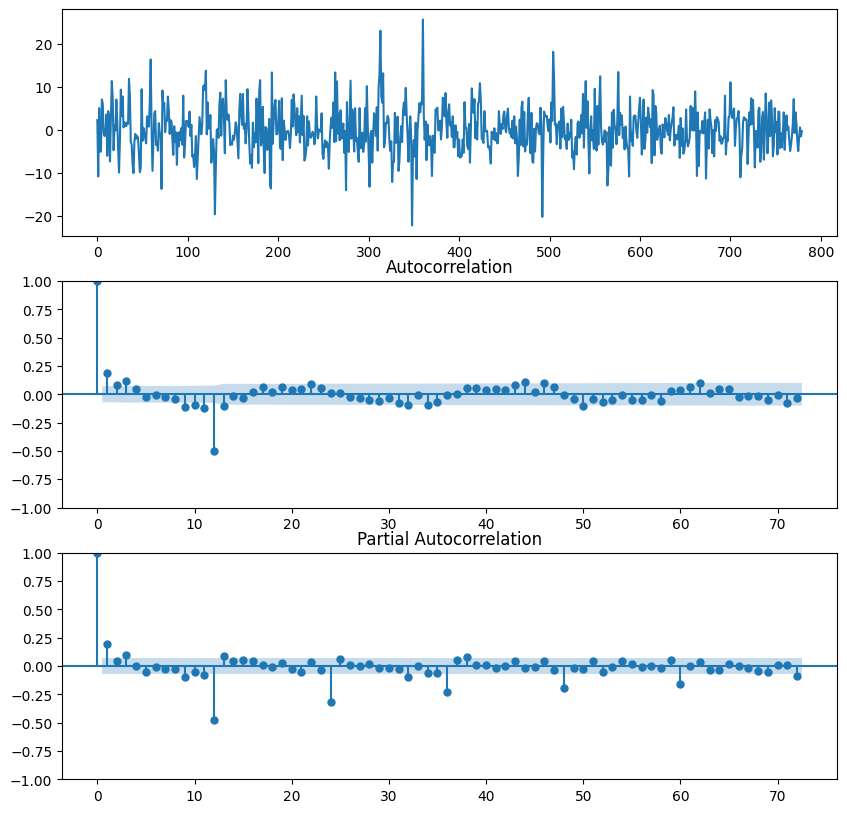

In [29]:
fig, axs = plt.subplots(3,1,figsize=(10,10))
axs[0].plot(monthly_temp['seas_diff'].values)
plot_acf(monthly_temp['seas_diff'].values, lags=72, ax=axs[1])
plot_pacf(monthly_temp['seas_diff'].values, lags=72, ax=axs[2]);

Based on our visual check, we fit a SARIMA model.

In [30]:
# Fit models to stationary data
train = monthly_temp['temp'][:-36] 
test = monthly_temp['temp'][-36:]

sarima_fit = ss.tsa.statespace.sarimax.SARIMAX(train, order=(3,0,3), seasonal_order=(0,1,1,12), trend='c').fit()

sarima_pred = sarima_fit.predict()
sarima_fore = sarima_fit.forecast(len(test))

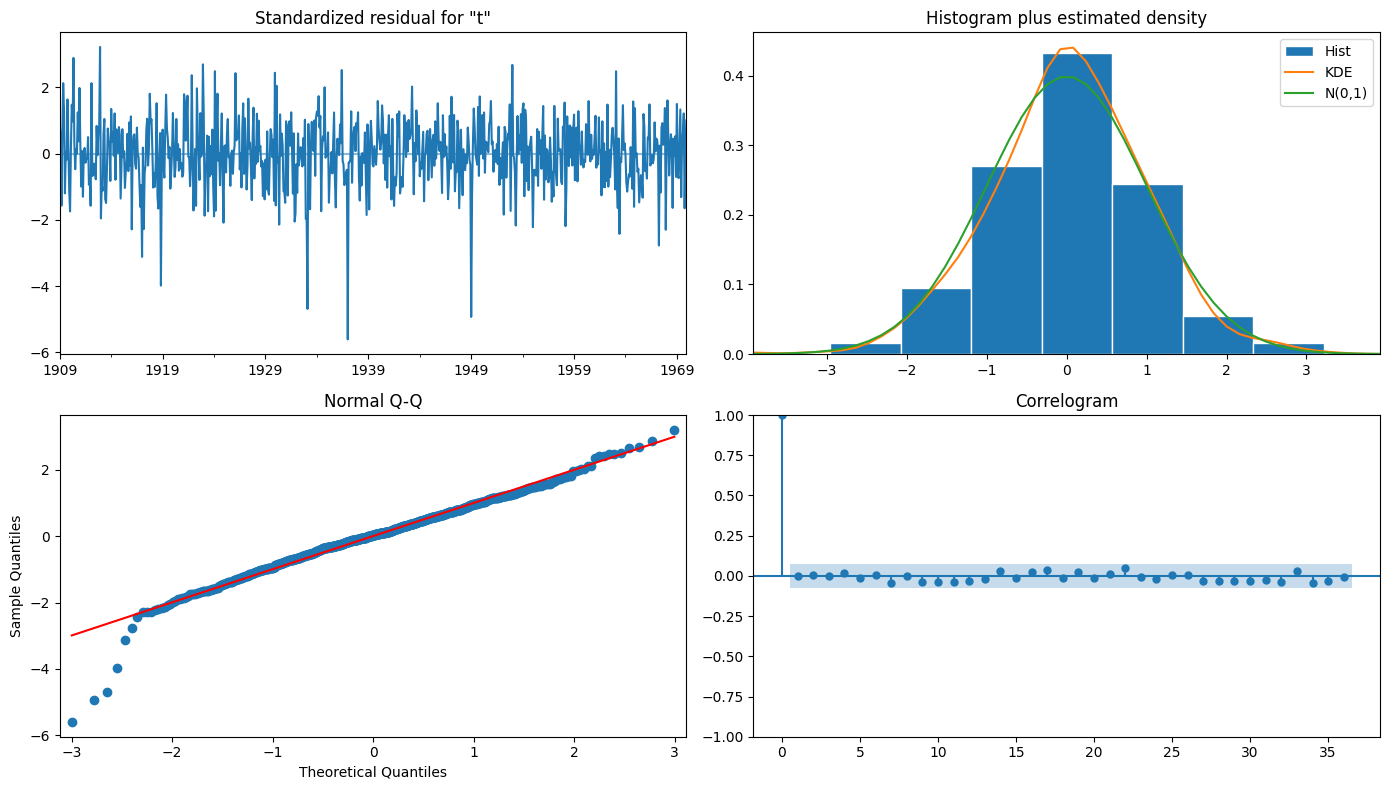

In [31]:
sarima_fit.plot_diagnostics(figsize=(14, 8),lags=36)
plt.tight_layout();

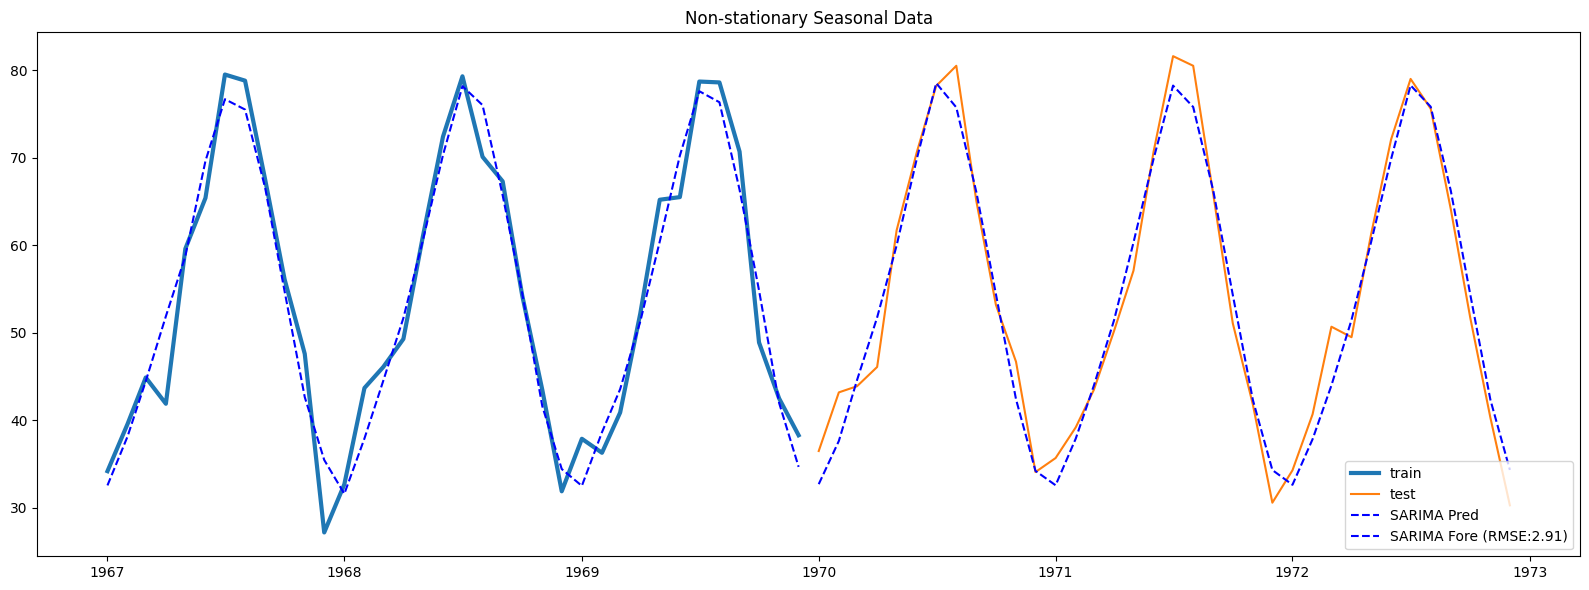

In [32]:
plt.figure(figsize=(16,6))
plt.plot(train[-36:], label='train', lw=3)
plt.plot(test, label='test')
plt.plot(sarima_pred[-36:], 'b--', label='SARIMA Pred')
plt.plot(sarima_fore, 'b--', label='SARIMA Fore (RMSE:%.2f)' % mse(sarima_fore,test)**0.5)
plt.legend(loc='lower right')
plt.title('Non-stationary Seasonal Data')
plt.tight_layout();

In [33]:
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  744
Model:             SARIMAX(3, 0, 3)x(0, 1, [1], 12)   Log Likelihood               -1994.952
Date:                              Tue, 23 Dec 2025   AIC                           4007.904
Time:                                      23:10:38   BIC                           4049.266
Sample:                                  01-01-1908   HQIC                          4023.859
                                       - 12-01-1969                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0110      0.011      0.993      0.321      -0.011       0.033
ar.L1          0.2562      0.308      0.833      0.405      -0.347       0.859
ar.L2         -0.5190      0.316     -1.643      0.100      -1.138       0.100
ar.L3          0.3774      0.249      1.514      0.130      -0.111       0.866
ma.L1         -0.0935      0.319     -0.293      0.769      -0.718       0.531
ma.L2          0.5361      0.316      1.699      0.089      -0.082       1.155
ma.L3         -0.2196      0.243     -0.902      0.367      -0.697       0.257
ma.S.L12      -0.9990      0.562     -1.776      0.076      -2.101       0.103
sigma2        12.7567      7.050      1.810      0.070      -1.061      26.574
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               254.71
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.57
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Define the grid of values to search

In [34]:
# possible values
p = [1, 2, 3]
d = [0]
q = [1, 2, 3]
P = [0, 1]
D = [1]
Q = [0, 1]
s = [12]

# create all combinations of possible values
pdq = list(product(p, d, q))
PDQs = list(product(P, D, Q, s))

pdqPDQS = list(product(pdq,PDQs))

print(len(pdq)*len(PDQs),'combinations')

36 combinations


In [35]:
%%time
best_RMSE = np.inf
for i in pdq:
    for j in PDQs:
        try:
            model = ss.tsa.statespace.sarimax.SARIMAX(train, order=i, seasonal_order=j, trend='c')
            fit_model = model.fit()
            forecast = fit_model.forecast(len(test))
        except:
            pass
        else:
            MAPE = (abs((test-forecast))/test).mean() # not suitable for data containing 0s
            RMSE = mse(test, forecast)**0.5
            AIC = fit_model.aic
            BIC = fit_model.bic
            if RMSE < best_RMSE:
                best_model = i,j
                best_RMSE = RMSE
            print('SARIMA(%s%s) -> MAPE:%.3f, RMSE:%.3f, AIC:%.1f, BIC:%.1f' % (str(i),str(j), MAPE, RMSE, AIC, BIC))
print('Best model (Predict):',best_model)

SARIMA((1, 0, 1)(0, 1, 0, 12)) -> MAPE:0.084, RMSE:4.623, AIC:4489.1, BIC:4507.5
SARIMA((1, 0, 1)(0, 1, 1, 12)) -> MAPE:0.047, RMSE:2.852, AIC:4003.7, BIC:4026.6
SARIMA((1, 0, 1)(1, 1, 0, 12)) -> MAPE:0.053, RMSE:3.381, AIC:4278.0, BIC:4301.0
SARIMA((1, 0, 1)(1, 1, 1, 12)) -> MAPE:0.048, RMSE:2.873, AIC:4003.5, BIC:4031.0
SARIMA((1, 0, 2)(0, 1, 0, 12)) -> MAPE:0.084, RMSE:4.636, AIC:4490.9, BIC:4513.8
SARIMA((1, 0, 2)(0, 1, 1, 12)) -> MAPE:0.047, RMSE:2.853, AIC:4005.5, BIC:4033.1
SARIMA((1, 0, 2)(1, 1, 0, 12)) -> MAPE:0.053, RMSE:3.392, AIC:4279.3, BIC:4306.8
SARIMA((1, 0, 2)(1, 1, 1, 12)) -> MAPE:0.048, RMSE:2.873, AIC:4005.4, BIC:4037.5
SARIMA((1, 0, 3)(0, 1, 0, 12)) -> MAPE:0.083, RMSE:4.612, AIC:4488.6, BIC:4516.2
SARIMA((1, 0, 3)(0, 1, 1, 12)) -> MAPE:0.048, RMSE:2.875, AIC:4005.1, BIC:4037.3
SARIMA((1, 0, 3)(1, 1, 0, 12)) -> MAPE:0.054, RMSE:3.394, AIC:4277.7, BIC:4309.9
SARIMA((1, 0, 3)(1, 1, 1, 12)) -> MAPE:0.048, RMSE:2.893, AIC:4005.1, BIC:4041.8
SARIMA((2, 0, 1)(0, 1, 0, 12

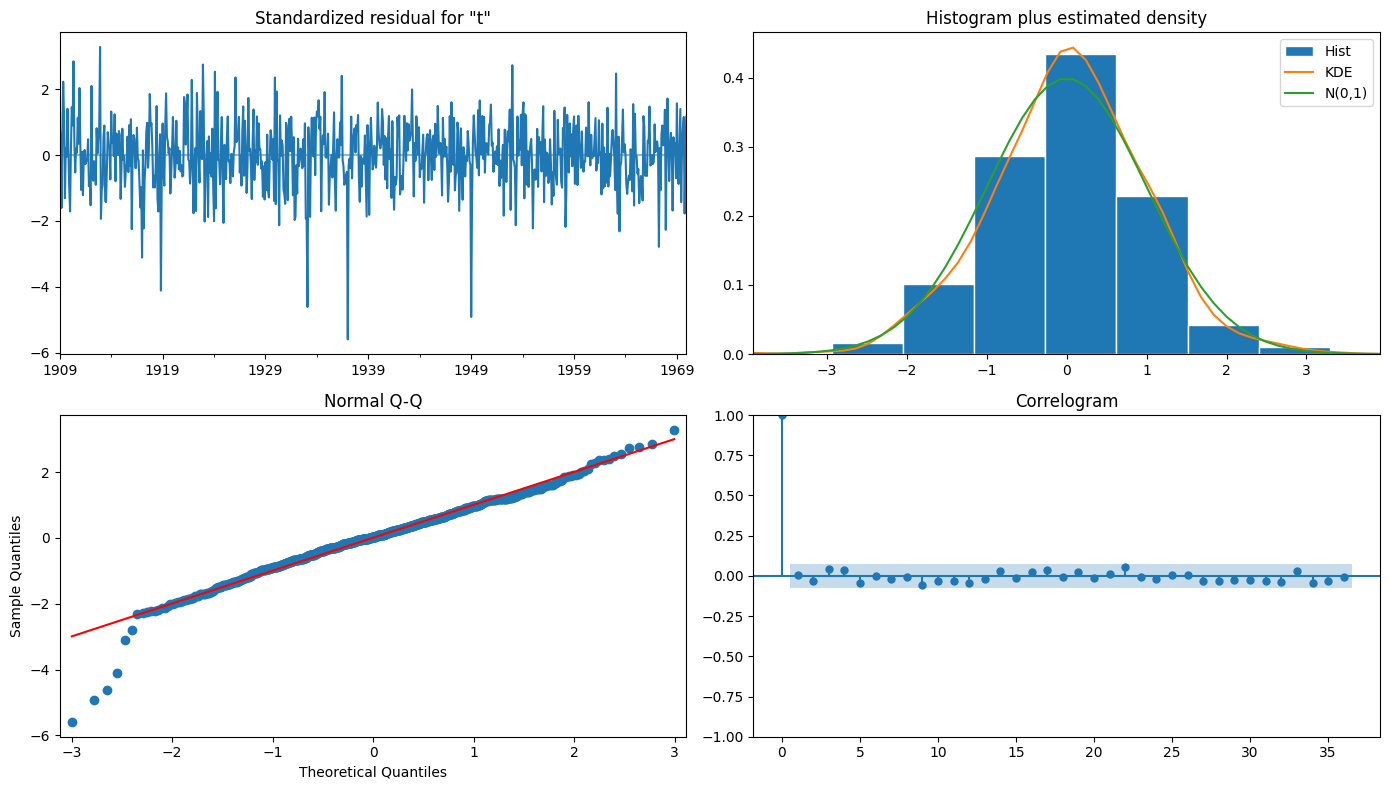

In [67]:
fit_best_model = ss.tsa.statespace.sarimax.SARIMAX(train, order=best_model[0], seasonal_order=best_model[1], trend='c').fit()
fit_best_model.plot_diagnostics(figsize=(14, 8),lags=36)
plt.tight_layout()

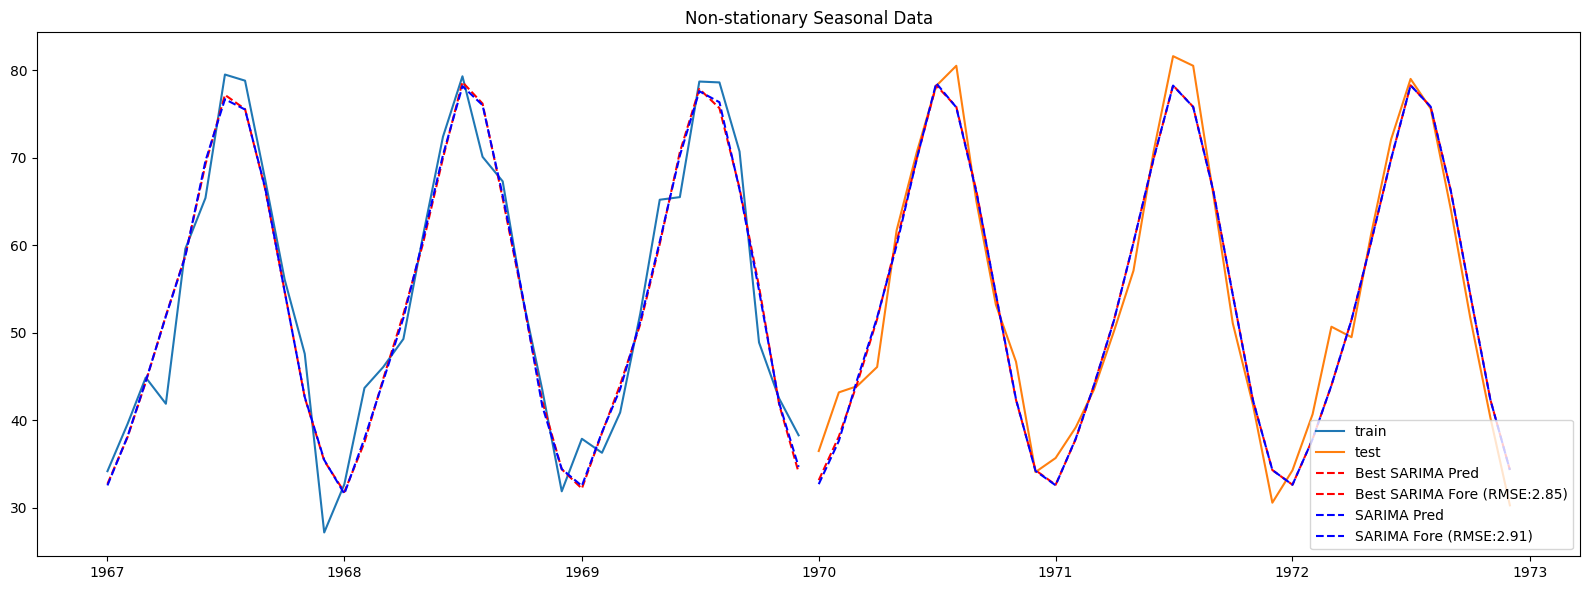

In [68]:
best_sarima_pred = fit_best_model.predict()
best_sarima_fore = fit_best_model.forecast(len(test))

plt.figure(figsize=(16,6))
plt.plot(train[-36:], label='train')
plt.plot(test, label='test')
plt.plot(best_sarima_pred[-36:], 'r--', label='Best SARIMA Pred')
plt.plot(best_sarima_fore, 'r--', label='Best SARIMA Fore (RMSE:%.2f)' % mse(best_sarima_fore,test)**0.5)
plt.plot(sarima_pred[-36:], 'b--', label='SARIMA Pred')
plt.plot(sarima_fore, 'b--', label='SARIMA Fore (RMSE:%.2f)' % mse(sarima_fore,test)**0.5)
plt.legend(loc='lower right')
plt.title('Non-stationary Seasonal Data')
plt.tight_layout();

---

## Summary

1. Autoregressive Moving Average (ARMA) models.
2. Autoregressive Integrated Moving Average (ARIMA) models.
3. SARIMA models (ARIMA model for data with seasonality).
4. Selecting the best model.

## Notes on measures of prediction performance and model complexity

### Prediction performance 

Use MSE and/or MAPE to evaluate the prediction performance of the model.

**Mean Squared Error (MSE)**

- MSE is the average of the squared differences between the observed values and the predictions.
- $MSE = \frac{1}{n}\sum_{i=1}^{n}(Y_i - \hat{Y}_i)^2$, where $Y_i$ is the actual observation and $\hat{Y}_i$ is the forecasted value.
- In SARIMA model selection, a model with a lower MSE is preferred, indicating better fit to the data.

**Mean Absolute Percentage Error (MAPE)**

- MAPE is the average of the absolute percentage errors of forecasts.
- $MAPE = \frac{100\%}{n}\sum_{i=1}^{n}\left|\frac{Y_i - \hat{Y}_i}{Y_i}\right|$, where $Y_i$ is the actual observation and $\hat{Y}_i$ is the forecasted value.
- MAPE expresses errors as a percentage, making it straightforward to understand the magnitude of forecasting errors.
- If you are comparing models that predict different quantities (e.g., dollars vs. units sold), the percentage error allows for a more apples-to-apples comparison.
- Also, when you're more interested in the relative size of the errors than in their absolute size, MAPE is relevant. 
- Finally, MAPE is useful when the magnitude of the data varies significantly.

### Model complexity

Use AIC or BIC to estimate the model's complexity.

**Akaike Information Criterion (AIC)**

- AIC is a measure of the relative quality of statistical models for a given set of data. 
- It deals with the trade-off between the goodness of fit of the model and the complexity of the model.
- $AIC = 2k - 2\ln(\hat{L})$, where $k$ is the number of parameters in the model, and $\hat{L}$ is the maximized value of the likelihood function for the model.
- The model with the **lowest AIC value** is preferred, as it fits the data well but is not overly complex.

**Bayesian Information Criterion (BIC)**

- Similar to AIC, the BIC is another criterion for model selection, but it introduces a stronger penalty for models with more parameters.
- $BIC = \ln(n)k - 2\ln(\hat{L})$, where $n$ is the number of observations, $k$ is the number of parameters, and $\hat{L}$ is the maximized likelihood.
- A **lower BIC value** indicates a better model, preferring simpler models to complex ones, especially as the sample size $n$ increases.

## Exercise

- Look at sensor data that tracks atmospheric CO2 from continuous air samples at Mauna Loa Observatory in Hawaii. This data includes CO2 samples from MAR 1958 to DEC 1980.

In [70]:
co2 = pd.read_csv('https://zenodo.org/records/10951538/files/arima_co2.csv?download=1', 
                  header = 0, names = ['date', 'co2'], skipfooter = 2)

# convert the column idx into a datetime object and set it as the index
co2['date'] = pd.to_datetime(co2['date'])
co2.set_index('date', inplace=True)

C:\Users\serhan.aydin\AppData\Local\Temp\ipykernel_28240\610923910.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  co2 = pd.read_csv('https://zenodo.org/records/10951538/files/arima_co2.csv?download=1',


- Determine the presence of main trend and seasonality in the data.
- Determine if the data are stationary.
- Split the data in train (90%) and test (10%).
- Find a set of SARIMAX candidate models by looking at the ACF and PACF.
- Perform a grid search on the model candidates.
- Select the best models, based on performance metrics, model complexity, and normality of the residuals.

**💡 Cheatsheet: coefficients setting**

<center>
    
|ACF Shape|Indicated Model|
|---|:---|
|Exponential, decaying to zero|AR model. Use the PACF to identify the order of the ARe model.|
|Alternating positive and negative, decaying to zero|AR model. Use the PACF to identify the order.|
|One or more spikes, rest are essentially zero|MA model, order identified by where plot becomes zero.|
|Decay, starting after a few lags|Mixed AR and MA (ARMA) model.|
|All zero or close to zero|Data are essentially random.|
|High values at fixed intervals|Include seasonal AR term.|
|No decay to zero|Series is not stationary.|
    
</center>